In [42]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams["figure.facecolor"] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [44]:
import argparse, sys, numpy as np, scipy as sc, os
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/modules/')
import foregrounds_with_scalings as fg

In [45]:
#params
spt_bands = np.asarray( [95, 150, 220] )
#planck_bands = []#np.asarray( [30, 44, 70, 100, 143, 217, 353] )#, 545, 857]
planck_bands = np.asarray( [100, 143, 217, 353] )#, 545, 857]
freqarr = sorted( np.concatenate( (spt_bands, planck_bands) ) )
only_auto_spectra = 0
freq0 = 150
lmax = 1e4
fg_model = 'reichardt' 
#fg_model = 'george'
if fg_model == 'george':
    fg_model_type = 'G15'
    spec_index_rg = -0.9##-0.9869688 ##-0.9
    spec_index_dg_po = 1.505 ##1.506845 ##1.505
    spec_index_dg_clus = 2.51 ##2.536784 ##2.51
    dg_clus_template_id = 0 ##1
    cib_temp = 20.
elif fg_model == 'reichardt':
    fg_model_type = 'R20'
    spec_index_rg = -0.76 ##-0.817
    spec_index_dg_po = 1.48 ##1.41
    spec_index_dg_clus = 2.23 ##2.29
    dg_clus_template_id = 0
    cib_temp = 25.

In [46]:
def fn_normalize(data,Nmin=0.,Nmax=1.):
    
    data = np.asarray( data )

    arrmin,arrmax=min(data),max(data)
    normed_data=(data-arrmin)/(arrmax-arrmin)
    normed_data=normed_data*Nmax+Nmin

    return normed_data

#for plotting
#same as Fig.3 of G15 https://arxiv.org/pdf/1408.3161.pdf
ymin, ymax = 0.5, 1e3
xmin, xmax = 2e3, 12e3

xmin, xmax = 10, 12e3
ymin, ymax = 0.5, 1e5

#get the colours for different frequencies
if (0):#only_auto_spectra: 
    freq_arr_norm = fn_normalize(freqarr, Nmin=0.,Nmax=255.)
    colorarr = [cm.jet(int(d)) for d in freq_arr_norm]
    colordic = {}
    for cntr, freq in enumerate( sorted(freqarr) ):
        colordic[(freq,freq)] = colorarr[cntr]
else:
    colorarr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(freqarr)**2)]
    colordic = {}
    cntr = 0
    for freq1 in sorted(freqarr):
        for freq2 in sorted(freqarr):
            if (freq2, freq1) in colordic: colordic[(freq1,freq2)] = colordic[(freq2,freq1)]
            colordic[(freq1,freq2)] = colorarr[cntr]
            cntr += 1

In [47]:
def fn_return_eff_bands(freq0, which_spt_0, freq1, freq2, which_spt_1, fg_component):

    band0 = '%dGHz' %(freq0)
    band1 = '%dGHz' %(freq1)
    band2 = '%dGHz' %(freq2)  
    
    #ref. frequency for reference band and ref. SPT experiment
    freq0_eff = fg.get_spt_effective_frequencies(which_spt_0, band0, fg_component)

    #get effective band centres for new SPT experiment at freq1, freq2
    freq1_eff = fg.get_spt_effective_frequencies(which_spt_1, band1, fg_component)
    freq2_eff = fg.get_spt_effective_frequencies(which_spt_1, band2, fg_component)

    return freq0_eff, freq1_eff, freq2_eff

def get_effective_frequencies(band, fg_component, fg_model):
    if fg_model == 'george':
        if fg_component == 'DG-Cl':
            spt_dic = {95: 100.318, 150: 156.760, 220: 221.805}
            planck_dic = {100: 103.759, 143: 146.010, 217: 225.376, 353: 355.693, 545: 552.131, 857:832.650}
        elif fg_component == 'DG-Po':
            spt_dic = {95: 99.8975, 150: 156.342, 220: 221.418}
            planck_dic = {100: 103.343, 143: 145.481, 217: 224.657, 353: 354.896, 545: 549.951, 857:829.128}    
    elif fg_model == 'reichardt':
        if fg_component == 'DG-Cl':
            spt_dic = {95: 100.213, 150: 156.661, 220: 221.724}
            planck_dic = {100: 103.759, 143: 146.010, 217: 225.376, 353: 355.693, 545: 552.131, 857:832.650}
        elif fg_component == 'DG-Po':
            spt_dic = {95: 99.9050, 150: 156.353, 220: 221.445}
            planck_dic = {100: 103.343, 143: 145.481, 217: 224.657, 353: 354.896, 545: 549.951, 857:829.128}    
    full_dic = {}
    for nu in spt_dic:
        full_dic[nu] = spt_dic[nu]
    for nu in planck_dic:
        full_dic[nu] = planck_dic[nu]
    if band in full_dic:
        return full_dic[band]        
    else:
        return band

<Figure size 900x600 with 0 Axes>

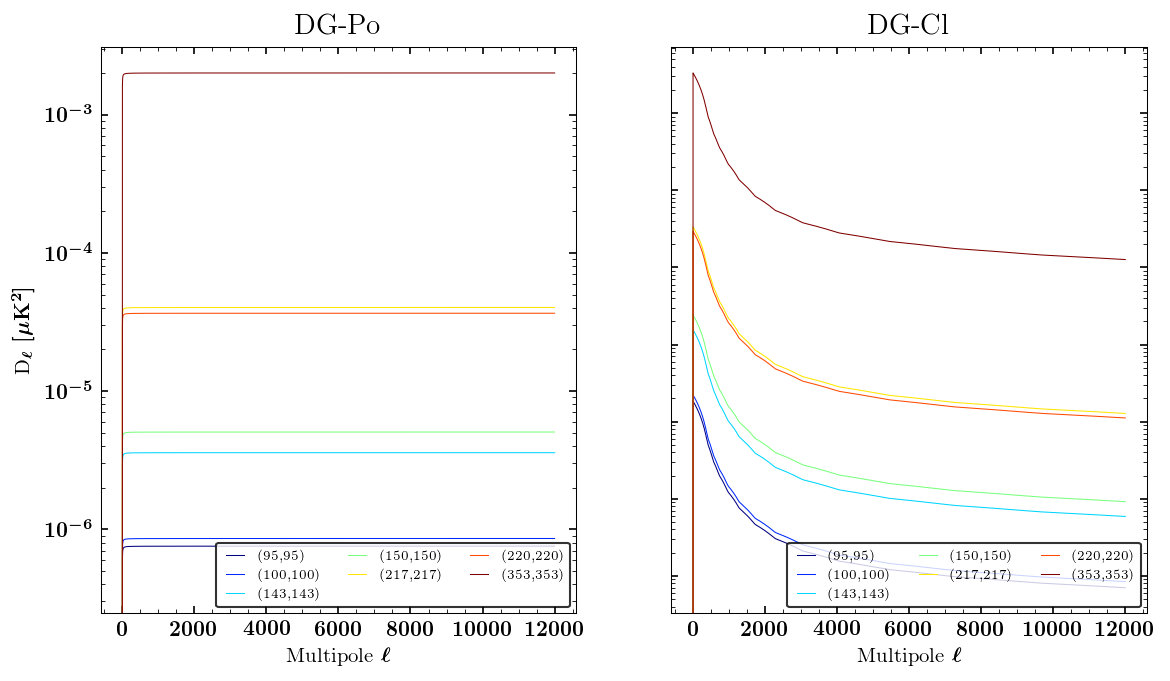

In [48]:
#DG galaxies
cl_cib_dic = {}
clf()
fig = figure(figsize=(9., 5.))
for fgcntr, fg_component in enumerate(['DG-Po', 'DG-Cl']):
    cl_cib_dic[fg_component] = {}
    ax =subplot(1,2,fgcntr+1, yscale = 'log')
    for freq1 in sorted(freqarr):
        for freq2 in sorted(freqarr):

            if only_auto_spectra and freq1 != freq2: continue

            #freq0_eff, freq1_eff, freq2_eff = fn_return_eff_bands(freq0_ghz, fg_model, freq1, freq2, fg_model, 'DG')                
            #freq0_eff, freq1_eff, freq2_eff = freq0, freq1, freq2
            freq0_eff = get_effective_frequencies(freq0, fg_component, fg_model)
            freq1_eff = get_effective_frequencies(freq1, fg_component, fg_model)
            freq2_eff = get_effective_frequencies(freq2, fg_component, fg_model)

            band1, band2 = '%dGHz'%(freq1), '%dGHz' %(freq2)
            band0 = '%dGHz' %(freq0)

            lwval = 0.5
            alphaval = 1.
            lsval = '-'
            labval = r'(%s,%s)' %(freq1, freq2)
            el, cl_dg_po, cl_dg_clus = fg.get_cl_dusty_galaxies(freq1_eff, freq2_eff, band0 = band0, fg_model = fg_model, spec_index_dg_po = spec_index_dg_po, spec_index_dg_clus = spec_index_dg_clus, dg_clus_template_id = dg_clus_template_id, cib_temp = cib_temp, return_ells = 1)

            dl_fac = el * (el+1) / 2/ np.pi

            if fgcntr == 0:                    
                cl_cib_dic[fg_component][(band1, band2)] = cl_dg_po
            else:
                cl_cib_dic[fg_component][(band1, band2)] = cl_dg_clus

            if freq1 != freq2: 
                continue
            dl_fac = 1.
            if fgcntr == 0:                    
                plot(el, cl_dg_po * dl_fac, ls = lsval, lw = lwval, label = labval, color = colordic[(freq1, freq2)], alpha = alphaval)
            else:
                plot(el, cl_dg_clus * dl_fac, ls = lsval, lw = lwval, label = labval, color = colordic[(freq1, freq2)], alpha = alphaval)
                
    #xlim(xmin, xmax)
    #ylim(ymin, ymax)
    xlabel(r'Multipole $\ell$');
    if fgcntr == 0:
        tit = 'DG-Po'
        legend(loc = 4, ncol = 3, fontsize = 6)
    else:
        tit = 'DG-Cl'
        legend(loc = 4, ncol = 3, fontsize = 6)
    title(r'%s' %(tit), fontsize = 14)
    if fgcntr == 0:
        ylabel(r'D$_{\ell}\ [\mu {\rm K}^{2}]$')
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)

cl_cib_dic['el'] = el
cl_cib_dic['fg_model'] = fg_model

In [49]:
if fg_model == 'george':
    fname = 'results/spt/sptsz_pol/cib/cl_cib_george15_onehalohaloterms'
elif fg_model == 'reichardt':
    fname = 'results/spt/sptsz_pol/cib/cl_cib_reichardt20_onehalohaloterms'
print(fname)
np.save(fname, cl_cib_dic)

results/spt/sptsz_pol/cib/cl_cib_reichardt20_onehalohaloterms


In [50]:
#store as text files
for fgc in ['DG-Po', 'DG-Cl']:
    if fg_model == 'george':
        fd = 'results/spt/sptsz_pol/cib/cl_cib_%s_george15_onehalohaloterms/' %(fgc)
    elif fg_model == 'reichardt':
        fd = 'results/spt/sptsz_pol/cib/cl_cib_%s_reichardt20_onehalohaloterms/' %(fgc)
    os.system('mkdir -p %s' %(fd))
    for bandkeys in cl_cib_dic[fgc]:        
        fname = '%s/%s_%s.txt' %(fd, bandkeys[0], bandkeys[1])        
        cl = cl_cib_dic[fgc][bandkeys]
        np.savetxt(fname, cl)
    fname = '%s/els.txt' %(fd)        
    np.savetxt(fname, el)

sys.exit()


SystemExit: 

In [ ]:
#Radio galaxies
ax = subplot(111, yscale = 'log')
for iter in range(1):
    for freq1 in sorted(freqarr):
        print(freq1)
        for freq2 in sorted(freqarr):

            if only_auto_spectra and freq1 != freq2: continue
            
            #freq0_eff, freq1_eff, freq2_eff = fn_return_eff_bands(freq0, fg_model, freq1, freq2, fg_model, 'RG')
            freq0_eff, freq1_eff, freq2_eff = freq0, freq1, freq2

            band1, band2 = '%dGHz'%(freq1), '%dGHz' %(freq2)
            band0 = '%dGHz' %(freq0)
            
            alphaval = 1.
            lsval = '-'
            lwval = 0.5
            labval = r'(%s,%s)' %(freq1, freq2)
            el, cl = fg.get_cl_radio(freq1_eff, freq2_eff, band0 = band0, fg_model = fg_model, spec_index_rg = spec_index_rg, return_ells = 1)
                
            dl_fac = el * (el+1) / 2/ np.pi

            plot(el, cl * dl_fac, ls = lsval, lw = lwval, label = labval, color = colordic[(freq1, freq2)], alpha = alphaval)
xlim(xmin, xmax)
ylim(ymin, ymax)
xlabel(r'Multipole $\ell$'); ylabel(r'D$_{\ell}\ [\mu {\rm K}^{2}]$')
legend(loc = 2, ncol = 3, fontsize = 8)
title(r'Radio', fontsize = 14)

In [ ]:
#tSZ
ax = subplot(111, yscale = 'log')
for iter in range(1):
    for freq1 in sorted(freqarr):
        for freq2 in sorted(freqarr):

            if only_auto_spectra and freq1 != freq2: continue
            
            #freq0_eff, freq1_eff, freq2_eff = fn_return_eff_bands(freq0_ghz, fg_model, freq1, freq2, fg_model, 'tSZ')
            freq0_eff, freq1_eff, freq2_eff = freq0, freq1, freq2
            print(freq0_eff, freq1_eff, freq2_eff)

            band1, band2 = '%dGHz'%(freq1), '%dGHz' %(freq2)
            band0 = '%dGHz' %(freq0)
            

            alphaval = 1.
            lsval = '-'
            lwval = 0.5
            labval = r'(%s,%s)' %(freq1, freq2)
            el, cl = fg.get_cl_tsz(freq1_eff, freq2_eff, band0 = band0, fg_model = fg_model, return_ells = 1)
            
            dl_fac = el * (el+1) / 2/ np.pi

            plot(el, cl * dl_fac, ls = lsval, lw = lwval, label = labval, color = colordic[(freq1, freq2)], alpha = alphaval)
xlim(xmin, xmax)
ylim(ymin, ymax)
xlabel(r'Multipole $\ell$'); ylabel(r'D$_{\ell}\ [\mu {\rm K}^{2}]$')
legend(loc = 2, ncol = 2, fontsize = 8)
title(r'tSZ', fontsize = 14)